<a href="https://colab.research.google.com/github/ND-CSE-30151/spring-2024/blob/main/notes/30-cooklevin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 30: The Cook-Levin Theorem

In [ ]:
#@title Setup
!pip install -qqq tock
!test -x /content/theory || git clone --quiet https://github.com/ND-CSE-30151/spring-2024 /content/theory
%cd -q /content/theory/notes
from tock import *
from cooklevin import *

<div class="alert alert-info">
    <p><b>Read</b> Section 7.4, "The Cook-Levin Theorem."</p>
</div>    

A Boolean formula is made out of variables, negation ($\neg x$ or $\bar x$), conjunction ($\land$), and disjunction ($\lor$). A formula $\phi$ is *satisfiable* iff there is a way to assign true or false values to variables such that $\phi$ is true.

The Boolean satisfiability problem (SAT) is

$$ \{ \phi \mid \text{$\phi$ is satisfiable} \}. $$

Now we want to show that SAT is NP-complete.

#### The big picture

This is a really long proof. I think it's helpful to first look at how it lines up with our skeleton proof.

First, we have to show that SAT is in NP, which is easy. Let's get that out of the way: it's enough to say that we can check a truth-assignment for $\phi$ in time linear in the length of $\phi$.

To show that SAT is NP-hard, we need to show that if SAT was decidable in polynomial time by a TM $R$, then, for any language $A$ in NP, we would be able to decide $A$ in polynomial time, in three steps: On input $w$,

1. Convert $w$ to a Boolean formula $\phi$.
2. Run $R$ on $\phi$.
3. If $R$ accepts, *accept*; else, *reject*.

So all the work is in defining a function $f$ that converts $w$ to a formula $\phi$, showing that that $\phi$ is satisfiable iff $w \in A$, and showing that $f$ runs in polynomial time.

#### The medium picture

Since we know that $A$ is in NP, there must be a NTM $N$ that decides it in polynomial time. That is, there is a function $t(n)$ such that for any input string $w$, $N$ accepts or rejects $w$ in at most $t(|w|)$ steps, and $t(n) \in O(n^k)$ for some $k$. For brevity, we write $t$ instead of $t(|w|)$ below.

Given $N$, $t$, and $w$, can can construct a *tableau*, which is a two-dimensional representation of a computation history for $N$ on $w$. The first row is the start configuration, and the following rows are the steps of the run. Each row is delimited by # on the left and right. Finally, if a row is an accepting configuration, the same configuration is repeated in the rows below it (this detail is missing from the book, but something like it seems necessary).

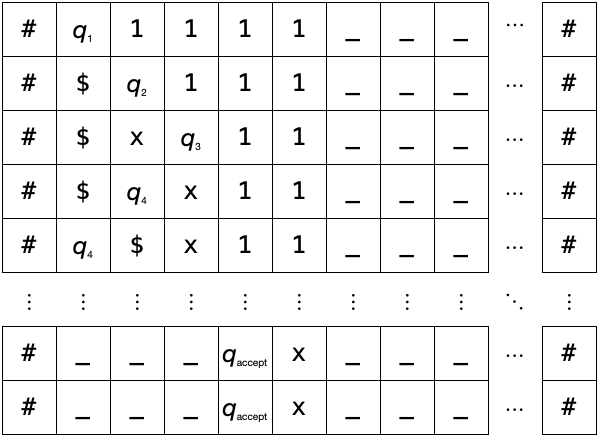

Because we only need to simulate $N$ up to $t$ steps, we can fix the size of the tableau in terms of $t$. There are $t+1$ rows: one row for the start configuration, plus one row for each step. And there are $t+4$ columns, because in $t$ steps, the head could move as far right as the $(t+1)st$ cell, plus one for the state, plus two for the #'s.

Now we need to write a giant formula $\phi$ that checks whether the tableau is an accepting computation history for $N$ on $w$. The variables of this formula are $x_{i,j,s}$, where $i$ is a row number, $j$ is a column number, and $s$ is either a tape symbol or a state. If $x_{i,j,s}$ is true, that means that cell $i,j$ contains symbol $s$. It's $\phi$'s job to check that a truth-assignment encodes a well-formed, accepting tableau.

The formula $\phi$ has four parts: $\phi = \phi_{\mathrm{cell}} \land \phi_{\mathrm{start}} \land \phi_{\mathrm{move}} \land \phi_{\mathrm{accept}}$. The purpose of these four parts is:

- $\phi_{\mathrm{cell}}$: Each cell contains exactly one symbol.
- $\phi_{\mathrm{start}}$: The first row of the tableau is the initial configuration of $N$.
- $\phi_{\mathrm{move}}$: Each row (except the first) is a configuration that legally follows the row above it according to $N$'s rules.
- $\phi_{\mathrm{accept}}$: The last row is an accepting configuration.

#### Every cell has exactly one symbol

Let $C = Q \cup \Gamma \cup \{\#\}$, the set of all possible symbols in a tableau cell. We ensure that every cell has exactly one symbol with the subformula:

\begin{align*}
\phi_{\text{cell}} = \bigwedge_{1 \leq i \leq t+1} \bigwedge_{1 \leq j \leq t+4} &\bigg[ && \text{for each cell,} \\
& \bigvee_{s \in C}  x_{i,j,s} \land {} && \text{each cell has at least one symbol} \\
& \bigwedge_{s,s' \in C, s \neq s'} \neg (x_{i,j,s} \land x_{i,j,s'}) && \text{and no cell has two symbols} \\
&\bigg]
\end{align*}

#### The first row is a start configuration

\begin{align*}
\phi_{\text{start}} = & x_{1,1,\#} \land {} && \text{left boundary} \\
                      & x_{1,2,q_0} \land{} && \text{start state} \\
                      & \bigwedge_{1 \leq i \leq n} x_{1,i+2,w_i} \land{} && \text{input string} \\
                      & \bigwedge_{n+1 \leq i \leq t+1} x_{1,i+2,\_} \land{} && \text{blank symbols} \\
                      & x_{1,t+4,\#} && \text{right boundary}
\end{align*}

#### Each row (except the first) follows from the previous row

This is the most complicated part of the formula.

\begin{align*}
\phi_{\text{move}} = \bigwedge_{1 \leq i \leq t} \bigwedge_{2 \leq j \leq t+1} &\bigg[ && \text{for each $2\times3$ window} \\
& \bigvee_{\text{$a_1, \ldots, a_6$ is a legal window}} x_{i,j-1,a_1} \land x_{i,j,a_2} \land x_{i,j+1,a_3} \land x_{i+1,j-1,a_4} \land x_{i+1,j,a_5} \land x_{i+1,j+1,a_6} && \text{the window is legal} \\
&\bigg]
\end{align*}

The book just gives a few examples of legal windows (Figure 7.39) but doesn't list them all out. If you like details to be completely worked out, here they are.

This is a legal window:

```
abc
abc
```

where a, b, and c are tape symbols, #, or $q_{\text{accept}}$.

Recall that if there is a transition $q \xrightarrow{b \rightarrow c, \text{L}} r$, then the configuration $uaqbv$ yields configuration $uracv$, where $u$ and $v$ are strings of tape symbols. So the following are all legal windows:

```
xya  yaq  aqb  qbx  bxy
xyr  yra  rac  acx  cxy
```

where $x$ and $y$ are any tape symbols or #.

A special case is when the head is at the left end of the tape and tries to move left ($qbv$ becomes $rcv$).

```
#qb  qbx
#rc  rcx
```

Similarly, if there is a transition $q \xrightarrow{b \rightarrow c, \text{R}} r$, then the configuration $uaqbv$ yields configuration $uacrv$. So the following are all legal windows:

```
yaq  aqb  qbx  bxy
yac  acr  crx  rxy
```

where $x$ and $y$ are any tape symbols or #.

These 12 cases cover all possibilities -- nothing else is a legal window.

#### The last row is an accepting configuration

$$\phi_{\text{accept}} = \bigvee_{2 \leq j \leq t+2} x_{t+1,j,q_{\text{accept}}} $$

#### Demo

Here's an NTM for $\{\texttt{1}^n \mid \text{$n$ is composite}\}$:

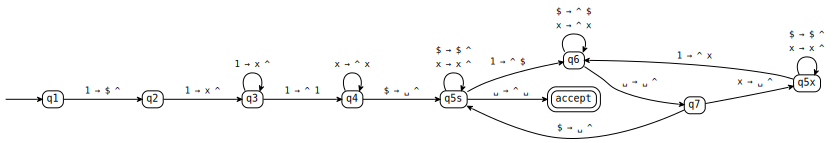

In [ ]:
m = read_csv("ntm-primes.csv")
m

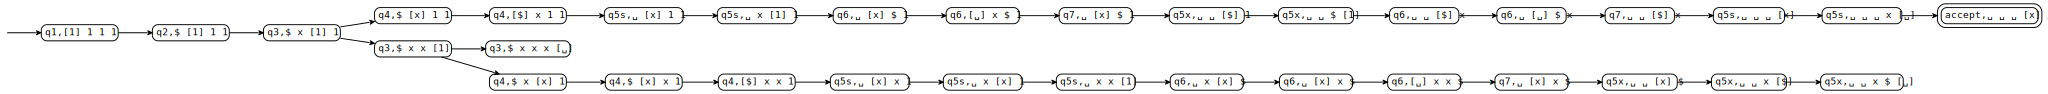

In [ ]:
run(m, ["1"]*4)

In [ ]:
run(m, ["1"]*4).shortest_path()

q1,[1] 1 1 1
q2,$ [1] 1 1
q3,$ x [1] 1
q4,$ [x] 1 1
q4,[$] x 1 1
q5s,␣ [x] 1 1
q5s,␣ x [1] 1
q6,␣ [x] $ 1
q6,[␣] x $ 1
q7,␣ [x] $ 1
q5x,␣ ␣ [$] 1


The running time of this NTM actually isn't bad -- bounded above by $3n^{3/2}$:

In [ ]:
# Print n, actual running time, upper bound on running time
for n in range(20):
    r = run(m, ["1"] * n)
    if r.has_path():
        print(n, len(r.shortest_path()), 3*n**1.5)

4 18 24.0
6 28 44.090815370097204
8 38 67.88225099390857
9 53 81.0
10 48 94.86832980505137
12 58 124.70765814495917
14 68 157.14961024450554
15 95 174.28425057933376
16 78 192.0
18 88 229.10259710444143


Now we construct the formula corresponding to the run of this machine on `0000`:

In [ ]:
phi = make_phi(m, ["1"]*4, 24)
print(phi.size()) # number of variables and operators in phi

9116869


It's too big to print, but we can look at the beginning:

In [ ]:
print(str(phi)[:1000], '...')

(x[1,1,#] | x[1,1,q6] | x[1,1,␣] | x[1,1,q2] | x[1,1,x] | x[1,1,q5x] | x[1,1,$] | x[1,1,1] | x[1,1,accept] | x[1,1,q3] | x[1,1,q4] | x[1,1,q7] | x[1,1,q5s] | x[1,1,q1]) & (~x[1,1,#] | ~x[1,1,q6]) & (~x[1,1,#] | ~x[1,1,␣]) & (~x[1,1,#] | ~x[1,1,q2]) & (~x[1,1,#] | ~x[1,1,x]) & (~x[1,1,#] | ~x[1,1,q5x]) & (~x[1,1,#] | ~x[1,1,$]) & (~x[1,1,#] | ~x[1,1,1]) & (~x[1,1,#] | ~x[1,1,accept]) & (~x[1,1,#] | ~x[1,1,q3]) & (~x[1,1,#] | ~x[1,1,q4]) & (~x[1,1,#] | ~x[1,1,q7]) & (~x[1,1,#] | ~x[1,1,q5s]) & (~x[1,1,#] | ~x[1,1,q1]) & (~x[1,1,q6] | ~x[1,1,#]) & (~x[1,1,q6] | ~x[1,1,␣]) & (~x[1,1,q6] | ~x[1,1,q2]) & (~x[1,1,q6] | ~x[1,1,x]) & (~x[1,1,q6] | ~x[1,1,q5x]) & (~x[1,1,q6] | ~x[1,1,$]) & (~x[1,1,q6] | ~x[1,1,1]) & (~x[1,1,q6] | ~x[1,1,accept]) & (~x[1,1,q6] | ~x[1,1,q3]) & (~x[1,1,q6] | ~x[1,1,q4]) & (~x[1,1,q6] | ~x[1,1,q7]) & (~x[1,1,q6] | ~x[1,1,q5s]) & (~x[1,1,q6] | ~x[1,1,q1]) & (~x[1,1,␣] | ~x[1,1,#]) & (~x[1,1,␣] | ~x[1,1,q6]) & (~x[1,1,␣] | ~x[1,1,q2]) & (~x[1,1,␣] | ~x[1,1,x]) & (~x[1

The last step is to modify the above proof so that $\phi$ is in 3CNF, that is, of the form

\begin{align*}
\phi &= (a_1 \lor b_1 \lor c_1) \land \ldots \land (a_m \lor b_m \lor c_m). \\
\end{align*}

There are $l$ variables, named $x_1, \ldots, x_l$. Each of the conjuncts $(a_j \lor b_j \lor c_j)$ is called a *clause* and there are $m$ of them. (Sipser sometimes uses $k$ for the number of clauses, except when he needs $k$ for something else. I'll try to stick to $m$.) Each clause has exactly three disjuncts, called *literals*. Each literal is either a variable $x_i$ or a negated variable $\neg x_i$. We'll be using 3CNF a lot, so remember this terminology and notation well.

For example, this formula gets used a lot as an example:

$$ \phi = (x_1 \lor x_1 \lor x_2) \land (\neg x_1 \lor \neg x_2 \lor \neg x_2) \land (\neg x_1 \lor x_2 \lor x_2). $$

It has $l = 2$ variables and $m = 3$ clauses. It has one satisfying assignment: $x_1 = 0, x_2 = 1$.

After modifying the proof (which I omit here), we have shown not only that SAT is NP-complete, but 3SAT. This will make future reductions easier.